### Revised TRAPPIST-1 Evolution Simulation

#### Sim Setup
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [9]:
import rebound
import reboundx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
sim.add(m=0.09)

# Define planet radii
r_earth = 4.264e-5 # in AU
radii = np.array([1.116, 1.097, 0.788, 0.920, 1.045, 1.129, 0.755]) * r_earth

# Define planet masses
m_earth = 3.003e-6 # in solar masses
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * m_earth

e0 = np.array([0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004])

# planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
planet_names = ['b', 'c', 'd']
num_planets = len(planet_names) # limits number of planets
radii = radii[:3]
masses = masses[:3] 
e0 = e0[:3]

a_b = 0.2 # starting semimajor axis for planet b

# Put planets 2% wider than 3:2 resonance
P_b = a_b**(3/2)
P_c = P_b * 3/2 * 1.02
P_d = P_c * 3/2 * 1.02
P0 = np.array([P_b, P_c, P_d])
a0 = P0**(2/3)

print("Initial semimajor axis values:")
print(a0)

# Add planets 
for i in range(num_planets):
    sim.add(m=masses[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

Initial semimajor axis values:
[0.2        0.26555692 0.35260238]


#### Sim Params
Based on Huang & Ormel. See `trappist1_migration.ipynb`.

In [10]:
# Free parameters
tau_a_earth = 5e3
C_e = 0.1 
r_c = 0.023
A_a = 100
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

#### $f_a$, $f_e$ functions
Determines how much damping is done by disk interactions, given by H&O Eq. 10 and Eq. 12.

In [11]:
q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

%matplotlib widget
def plot_f_functions():
    fig, ax = plt.subplots()
    fig.set_figwidth(4.0)
    fig.set_figheight(4.0)

    xs = np.linspace(0, 3*r_c, 1000)
    f_a_vals, f_e_vals = f_functions(xs)
    ax.plot(xs, f_a_vals, label='f_a')  
    ax.plot(xs, f_e_vals, label='f_e')  
    plt.ylabel("$f_a$ or $f_e$")
    plt.xlabel("Distance from the star")
    plt.axvline(r_c-Delta, color='gray', ls='--', alpha=0.3)
    plt.axvline(r_c, color='gray', ls='--', alpha=0.5)
    plt.axvline(r_c+Delta+1/A_a, color='gray', ls='--', alpha=0.3)
    plt.legend()
    plt.show()

# plot_f_functions()
print(r_c - Delta)
print(r_c + Delta + 1 / A_a)

0.02162
0.03438


#### Note on damping timescales ($\tau$)
$\tau$ values are given by H&O Eqs. 6, 7, and 14.

If I were to use `modify_orbits_forces` for damping, I'd have to take into account two $\tau_e$'s. REBOUNDx doesn't allow making two separate forces, but I think I'm able to combine the two by computing $\tau_{e,\mathrm{total}} = (\tau_{e,\mathrm{disk}} * \tau_{e,\mathrm{star}}) / (\tau_{e,\mathrm{disk}} + \tau_{e,\mathrm{star}}$). I say this because the eccentricity component of the force equations Eqs. 4 and 13 are identical, and this quantity should have the effect of both $\tau_e$'s.

I do not know how H&O derived their value for $\tau_{e,\mathrm{disk}}$ in Eq. 7. Using their formula, the values for $\tau_{e,\mathrm{disk}}$ I'm computing are in order unity, which seems way too small (and results in $e$ instantly dropping to 0). Perhaps, they added an extra factor of $h^2$ ($h$ being the aspect ratio); I say this because when I removed this term, $\tau_{e,\mathrm{disk}}$ is around $-360 \text{ yrs}$ and the graph looks much more like expected. 

In [12]:
def get_taus(current_a_vals):
    '''
    Computes damping timescales based on current semimajor axis values.
    
    Parameters:
        current_a_vals: 1D NumPy array of current semimajor axis values.
    
    Returns:
        tau_a: semimajor axis damping timescale.
        tau_e: eccentricity damping timescale.
    '''
    f_a_vals, f_e_vals = f_functions(current_a_vals)
    tau_a = -tau_a_earth * (q_earth / q_vals) / f_a_vals # negative so damping?
    tau_e_disk = C_e * tau_a * f_a_vals / f_e_vals # I removed a h^2 here
    tau_e_star = 7.63e5 * Q_sim * (masses/m_earth) * (1/M_star)**1.5 * (r_earth/radii)** 5 * (current_a_vals/0.05)**6.5
    tau_e = (tau_e_disk * tau_e_star) / (tau_e_disk + tau_e_star) # combining the two based on Eqs. 4 and 13
    return tau_a, tau_e

# Peek tau values
current_a_vals = a0
print(f"tau_a: {get_taus(current_a_vals)[0]}")
print(f"tau_e: {get_taus(current_a_vals)[1]}")

tau_a: [ -3639.01018923  -3822.62996942 -12886.59793814]
tau_e: [ -363.90101893  -382.26299694 -1288.65979382]


#### Implementing REBOUNDx forces


In [13]:
# Code using modify_orbits_forces
rebx = reboundx.Extras(sim)

# Planet-disk interaction
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

#### Data storage
For every `sim.dt`, the simulation must update the time-scales ($\tau_a$ and $\tau_e$). However, it is slow to record data at every such step. So, only certain times will be recorded and plotted in the end.

Note that the actual amount of time integrated is `t_spacing*n_out` $\approx$ `stage1_end`.

In [14]:
sim.dt = planets[0].P / 20 # 1/20 of planet b

def data_df(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "P": np.zeros(n_out),
        "P_ratio": np.zeros(n_out),
        "tau_a": np.zeros(n_out),
        "tau_e": np.zeros(n_out)
    })

# Set up times for integration & data collection
stage1_end = 100000 # yrs
n_out = 1000 # number of data points to collect

num_dts = int(stage1_end / sim.dt)
i_spacing = round(num_dts / n_out) # index between each data point
t_spacing = i_spacing * sim.dt     # time between each data point

stage1_times = np.linspace(0, t_spacing*n_out, i_spacing*n_out)  # all times to integrate over
stage1_times_recorded = stage1_times[::i_spacing]        # times to record data
stage1_data = {name : data_df(n_out, stage1_times_recorded) for name in planet_names[:num_planets]}

def stage2():
    # stage2_end = 20
    # stage2_times = np.arange(stage1_end, stage2_end, sim.dt)
    # stage2_steps = len(stage2_times)

    # stage2_data = {name : data_df(stage2_steps, stage2_times) for name in planet_names[:num_planets]}

    # total_data = deepcopy(stage1_data)
    # for name in stage1_data:
    #     total_data[name] = pd.concat(
    #         [stage1_data[name], stage2_data[name]],
    #         axis=0,
    #         ignore_index=True
    #     )

    # display(stage1_data['b'])
    pass

#### It's time to integrate

$\tau_a$ and $\tau_e$ must be updated with `sim.dt`. We can also choose which planets to apply Type I migration on.

In [ ]:
tstart = time()
stop_sim = False

# Choose planets that will have Type I migration
typeI_planets = ['d']

for i, t in enumerate(stage1_times):  
    sim.integrate(t)
    
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    tau_a, tau_e = get_taus(current_a_vals)
    
    for p in range(num_planets):
        if planet_names[p] in typeI_planets:
            planets[p].params["tau_a"] = tau_a[p]
            planets[p].params["tau_e"] = tau_e[p]

        # Record data if i is divisible by i_spacing
        if i % i_spacing == 0:
            name = planet_names[p]
            j = i/i_spacing # index for data storage
            stage1_data[name]["a"][j] = planets[p].a
            stage1_data[name]["e"][j] = planets[p].e
            # stage1_data[name]["P"][j] = planets[p].P
            # stage1_data[name]["tau_a"][j] = tau_a[p]
            # stage1_data[name]["tau_e"][j] = tau_e[p]
            if p != num_planets-1: # don't record period ratio for last planet
                stage1_data[name]["P_ratio"][j] = planets[p+1].P / planets[p].P
            
            # Stop sim if planet goes into star
            if planets[p].a < 0.001:
                stop_sim = True
    
    if stop_sim:
        print(f"Stopped integration at t={t}")
        break
        
print(f'finished integration in {time()-tstart:.4} sec')

Stopped integration at t=72197.52446232797
finished integration in 226.9 sec


#### Plot it!

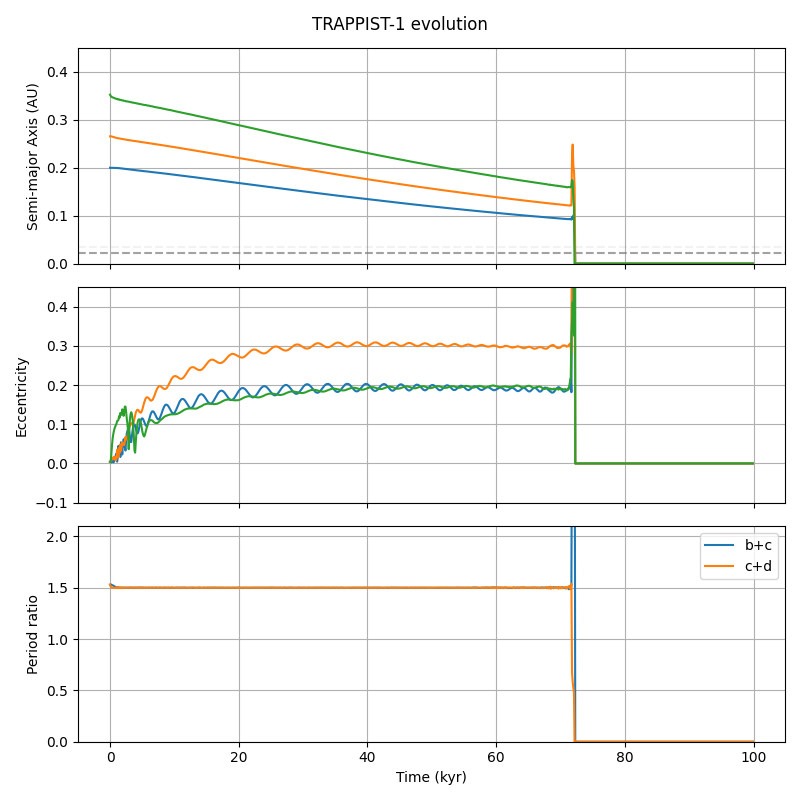

In [ ]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        ax1.plot(stage1_times_recorded/1000, stage1_data[name]["a"], label=name)
        ax2.plot(stage1_times_recorded/1000, stage1_data[name]["e"], label=name)
        if p != num_planets-1:
            ax3.plot(stage1_times_recorded/1000, stage1_data[name]["P_ratio"], label=f"{name}+{planet_names[p+1]}")
        # ax4.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        # ax5.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        
    plt.xlabel("Time (kyr)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period ratio")
    # ax4.set_ylabel("tau_a")
    # ax5.set_ylabel("tau_e")
    
    ax1.set_ylim(0,0.45)
    ax2.set_ylim(-0.1,0.45)
    ax3.set_ylim(0,2.1)
    # ax4.set_ylim(-10000, 0)s
    # ax5.set_ylim(-10000, 0)
    
    # Plot truncation radius 
    ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)
    ax1.axhline(r_c - Delta, color='gray', ls='--', alpha=0.1)
    ax1.axhline(r_c + Delta + 1/A_a, color='gray', ls='--', alpha=0.1)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True); # ax4.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()